<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C(%E5%88%86%E7%B1%BB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
print("Tensorflow Version:",tf.__version__)

Tensorflow Version: 2.9.2


# 数据读入/转换

In [4]:
# 创建项目子目录
def makepath(Subdirectory):
    try:
        os.mkdir(Subdirectory)
    except FileExistsError:
        pass

In [5]:
# 原始图像文件
raw_filepath_list = ["/content/gdrive/MyDrive/data/approved_pic", "/content/gdrive/MyDrive/data/disapproved_pic"]

# 像素统一化之后的文件
standard_filepath_list = ["/content/gdrive/MyDrive/data/approved_256", "/content/gdrive/MyDrive/data/disapproved_256"]

for raw_filepath in raw_filepath_list:
    makepath(raw_filepath)
for standard_filepath in standard_filepath_list:
    makepath(standard_filepath)

In [6]:
# 获取每个类别的图片文件列表
def get_file_list(filepath, ext_list):
    file_list = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if os.path.splitext(file)[1] in ext_list:
                # file_list.append(os.path.join(root, file))
                file_list.append(os.path.join(filepath, file))
        return file_list


cars_file_list = get_file_list(filepath='/content/gdrive/MyDrive/data/approved_pic', ext_list=['.jpg'])
cats_file_list = get_file_list(filepath='/content/gdrive/MyDrive/data/disapproved_pic', ext_list=['.jpg'])

In [7]:
#批量改变图片像素
def imgresize(file_list,savepath, width, height):
    i = 0
    for filepath in file_list:
        try:
            im = Image.open(filepath)
            new_im =im.resize((width, height))
            i+=1
            new_im.save(savepath + '/' + str(i) + '.jpg') 
            print('图片' + str(filepath.split('/')[-1]) + '像素转换完成')
        except OSError as e:
            print(e.args)

In [ ]:
# 像素转化
imgresize(file_list=cars_file_list, savepath="/content/gdrive/MyDrive/data/approved_256", width=256, height=256)
imgresize(file_list=cats_file_list, savepath="/content/gdrive/MyDrive/data/disapproved_256", width=256, height=256)

In [9]:
# 获取像素处理后的图像列表
cars_256_file_list = get_file_list(filepath='/content/gdrive/MyDrive/data/approved_256', ext_list=['.jpg'])
cats_256_file_list = get_file_list(filepath='/content/gdrive/MyDrive/data/disapproved_256', ext_list=['.jpg'])

In [23]:
# 所有图像的列表
file_list_all = cars_256_file_list[:500] + cats_256_file_list[:500]  #为了省内存，只选前500个
print('批准药物数量：',len(cars_256_file_list))
print('尚未批准药物数量：',len(cats_256_file_list))
print('总共药物数量：',len(file_list_all))

批准药物数量： 2006
尚未批准药物数量： 2136
总共药物数量： 1000


In [24]:
# 图像转化为像素点数组
Pixel_list = []
for filename in file_list_all:
    im = Image.open(filename)
    width,height = im.size
    imgL = im.convert("L") 
    Core = imgL.getdata()
    img_arr = np.array(Core, dtype='float32') / 255.0
    img_list = img_arr.tolist()
    Pixel_list.extend(img_list)

len(Pixel_list)

65536000

In [25]:
#像素点值转化为数组
X = np.array(Pixel_list).reshape(len(file_list_all), width, height)
len(X)
print(X.shape)

(1000, 256, 256)


In [42]:
# 分类标签
class_names = ['approved', 'disapproved']
#用字典储存图像信息
dict_label = {0:'approved', 1:'disapproved'}

In [43]:
label = [0]*len(cars_256_file_list[:500]) + [1]*len(cats_256_file_list[:500])
len(label)
y = np.array(label)

In [44]:
#按照4:1的比例将数据划分训练集和测试集
train_images, test_images, train_labels, test_labels = train_test_split(
        X, y, test_size=0.2, random_state=0)

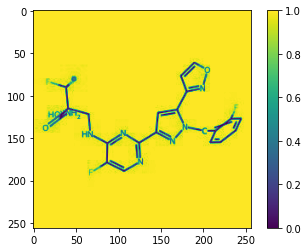

In [45]:
plt.figure()
plt.imshow(train_images[9])
plt.colorbar()
plt.grid(False)
plt.savefig("./train1.jpg",dpi=200)

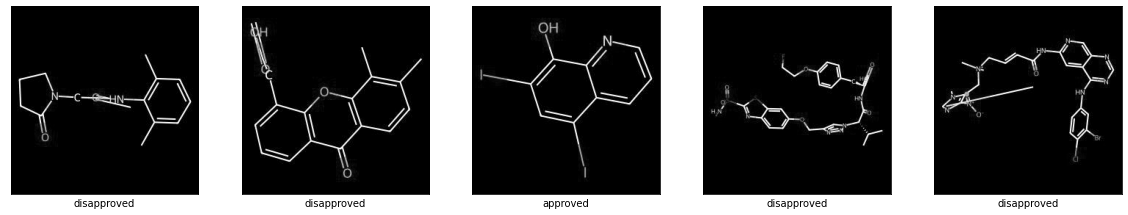

In [46]:
#显示来自训练集的前25个图像，并在每个图像下面显示类名。
#验证数据的格式是否正确，准备构建神经网络
plt.figure(figsize=(20,20))
for i in range(0,5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
    plt.savefig("./5.jpg", dpi=200)

# 模型搭建/训练

In [69]:
#第一个输入层有128个节点(或神经元)。
#第二个(也是最后一个)层是2个节点的softmax层————返回一个2个概率分数的数组，其和为1。
#每个节点包含一个分数，表示当前图像属于两个类别的概率
# 设置层
# 神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。
# 大多数深度学习都包括将简单的层链接在一起。大多数层（如 tf.keras.layers.Dense）都具有在训练期间才会学习的参数。

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(256, 256)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(class_names))
])

In [77]:
# 编译模型
# 在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：
# 损失函数 - 用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。
# 优化器 - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
# 指标 - 用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=20)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


Epoch 1/20
25/25 [==============================] - 2s 58ms/step - loss: 0.6933 - accuracy: 0.5025
Epoch 2/20
25/25 [==============================] - 1s 57ms/step - loss: 0.6934 - accuracy: 0.5025
Epoch 3/20
25/25 [==============================] - 2s 75ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 4/20
25/25 [==============================] - 2s 83ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 5/20
25/25 [==============================] - 2s 82ms/step - loss: 0.6933 - accuracy: 0.5025
Epoch 6/20
25/25 [==============================] - 1s 57ms/step - loss: 0.6934 - accuracy: 0.4725
Epoch 7/20
25/25 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 8/20
25/25 [==============================] - 1s 57ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 9/20
25/25 [==============================] - 1s 57ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 10/20
25/25 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 11/

# 模型预测/绘图/检验

In [78]:
# probability_model
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
pred_label = dict_label[np.argmax(predictions[0])]
print(pred_label)

7/7 [==============================] - 0s 16ms/step
approved


In [73]:
# 定义画图函数
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = '#00BC57'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)
  
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(len(class_names)))
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('#00BC57')

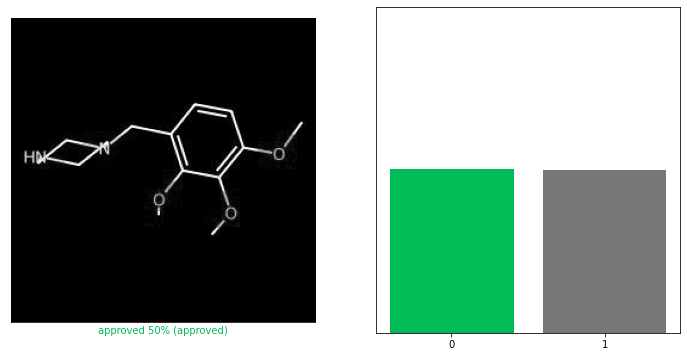

In [79]:
# 查看指定序号的分子预测情况
i = 8
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

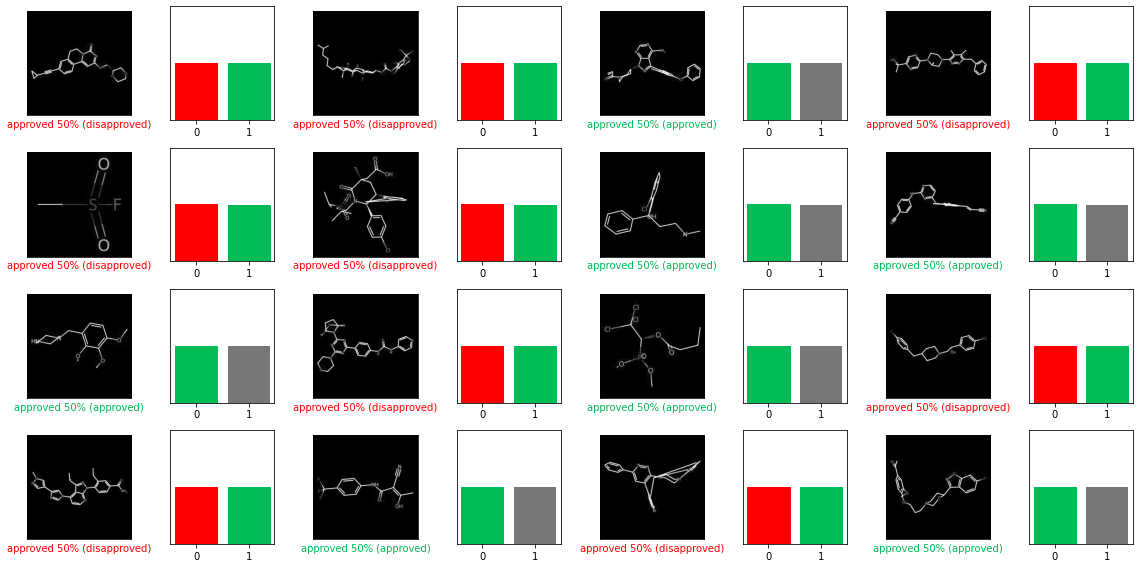

In [80]:
#绘制预测标签和真实标签以及预测概率柱状图
#正确的预测用绿色表示，错误的预测用红色表示
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.savefig("./pred16.png",dpi=300)
plt.show()

(256, 256)
(1, 256, 256)


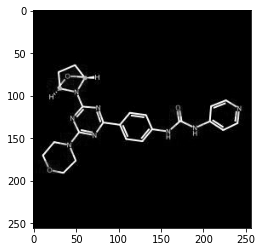

In [81]:
#最后，利用训练后的模型对单个图像进行预测。
#从测试数据集中获取第10个图像
img = test_images[9]
print(img.shape)
plt.imshow(img, cmap=plt.cm.binary)
# tf.keras 模型经过了优化，可同时对一个批或一组样本进行预测。
#因此，即便您只使用一个图像，您也需要将其添加到列表中：
img = (np.expand_dims(img,0))
print(img.shape)

1/1 [==============================] - 0s 23ms/step
[[0.5017625  0.49823755]]
approved


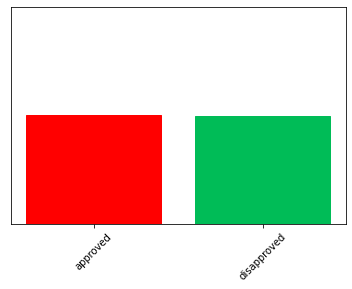

In [82]:
# 预测图像:
probability_single = probability_model.predict(img)
print(probability_single)
pred_label = dict_label[np.argmax(probability_single[0])]
print(pred_label)
# 可视化预测概率
plot_value_array(1, probability_single[0], test_labels)
_ = plt.xticks(range(len(class_names)), class_names, rotation=45)

# 待预测未知图像(256x256)

图片1.jpg像素转换完成


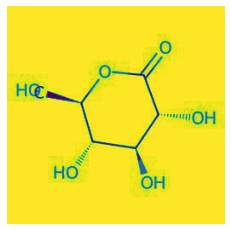

(1, 256, 256)
1/1 [==============================] - 0s 25ms/step
approved
第1张图像识别为: approved


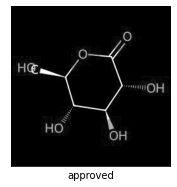

In [83]:
# 待预测未知图像(256x256)
try:
    os.mkdir("./test")
except FileExistsError:
    pass

preds_file_list      = get_file_list(filepath='./test/preds',   ext_list=['.jpg', '.png'])
imgresize(file_list  = preds_file_list, savepath="./test/preds_256",   width=256, height=256)

preds_256_file_list  = get_file_list(filepath='./test/preds_256',   ext_list=['.jpg', '.png'])

img = Image.open(preds_256_file_list[0])
RGB = np.array(img)
R = RGB[:,:,0] # 所有行所有列第一通道R 
G = RGB[:,:,1] # 所有行所有列第二通道G 
B = RGB[:,:,2] # 所有行所有列第三通道B 
R.shape

imgL = img.convert("L") 
gray = np.array(imgL)
gray.shape

for filename in preds_256_file_list:
    img = Image.open(filename)
    # 转换为灰度图
    img = img.convert("L") 
    gray = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# 图像转化为像素点数组
Pixel_list = []
for filename in preds_256_file_list:
    im = Image.open(filename)
    width,height = im.size
    imgL = im.convert("L") 
    Core = imgL.getdata()
    img_arr = np.array(Core, dtype='float32') / 255.0
    img_list = img_arr.tolist()
    Pixel_list.extend(img_list)

len(Pixel_list)


#像素点值转化为数组
val_images = np.array(Pixel_list).reshape(len(preds_256_file_list), width, height)
len(val_images)
print(val_images.shape)


# 预测概率
predictions = probability_model.predict(val_images)
pred_label = dict_label[np.argmax(predictions[0])]
print(pred_label)


# 字典编号翻译成对应的标签
for i in range(len(val_images)):
    print('第'+str(i+1)+'张图像识别为: ' + dict_label[np.argmax(predictions[i])])


pred_labels = [ dict_label[np.argmax(predictions[i])] for i in range(len(val_images)) ]
# 可视化多个图像
M = []
for filename in preds_256_file_list:
    im = Image.open(filename)
    width,height = im.size
    im_L = im.convert("L") 
    Core = im_L.getdata()
    arr1 = np.array(Core,dtype='float')/255.0
    list_img = arr1.tolist()
    M.extend(list_img)

pred_images = np.array(M).reshape(len(preds_256_file_list),width,height)

num_rows=2
num_cols=3
plt.figure(figsize=(20, 10))
for i, img in enumerate(pred_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(pred_labels[i])
